In [14]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python37_MacOS64')
import pygplates

from collections import defaultdict

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon
from shapely.geometry import LineString

import matplotlib.cm as cm
import matplotlib as mpl

import glob
import os
import pickle5 as pickle

In [15]:
#sort files in a folder
#sort numerically because glob doens't >.>
import re

#turn a string of numbers in a file name into integers
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s

#split a filename into alpha and numerical components
def alphanum_key(s):
    return [tryint(c) for c in re.split('([0-9]+)', s)]

def sort_nicely(l):
    return sorted(l, key=alphanum_key)

In [16]:
def sum_results(dataframe):
    
    '''
This function takes the dataframe and calculates seafloor production
from two of the columns and then sums for each timestep.

Returns: Pandas dataframe of two columns:
            1) Seafloor production (km2)
            2) Time (Ma)

    '''
    #set timerange
    times = np.arange(dataframe['Time_Ma'].min(),
                      dataframe['Time_Ma'].max()+1,
                      1)
    #set empty array for results
    seafloor_production = np.zeros(np.shape(times))
    mean_spreading_rate = np.zeros(np.shape(times))
    total_length = np.zeros(np.shape(times))
    
    #loop through times
    for ind, time in enumerate(times):

        #get just the entries from the timestep
        tmp_df = dataframe.loc[dataframe['Time_Ma'] == time]
        
        #plate velocity in cm/a, * 10 for mm/a or km/Ma
        tmp_plate_velocity = tmp_df['Plate_Velocity'] * 10
        #length of segment in km
        tmp_length = tmp_df['Length_km']
        
        #get production at timestep
        tmp_prod = np.sum(tmp_plate_velocity * tmp_length)
        #get mean spreading rate
        tmp_mean_spreading_rate = np.mean(tmp_plate_velocity)
        #get total ridge length
        tmp_total_length = np.sum(tmp_length)

        seafloor_production[ind] = tmp_prod
        mean_spreading_rate[ind] = tmp_mean_spreading_rate
        total_length[ind] = tmp_total_length
        
    #convert to dataframe
    seafloor_produciton_df = pd.DataFrame({'Time_(Ma)': times,
                                           'Seafloor_prod_(km2)': seafloor_production,
                                           'Ridge_length_(km)': total_length,
                                           'Mean_spreading_rate_(km/Ma)':mean_spreading_rate
                                          },

                               columns=['Time_(Ma)',
                                        'Seafloor_prod_(km2)',
                                        'Ridge_length_(km)',
                                        'Mean_spreading_rate_(km/Ma)'])
    return seafloor_produciton_df

In [17]:
#set directories
datadir = '/Users/andrew/Documents/Data/plate_boundary_analysis/'
platedir = '/Users/andrew/Documents/GitHub/EarthBytePlateMotionModel-ARCHIVE/Muller++_2015_AREPS_CORRECTED/'
savedir = '/Users/andrew/Documents/Data/Gernon_shallow_ridges/'
# import previously made file in 'extract velocities'
file = '%sPlateBoundaryTypes_230-0_20200904.h5' % datadir
df = pd.read_hdf(file,'Statistics_table')
tags = df['FeatureType']

rotfile = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS.rot' % platedir
COBs = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_COB_Terranes.gpml' % platedir
coastlines = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml' % platedir
input_topology_filename = ['%sGlobal_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml' % platedir,
                           '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml' % platedir]

rotation_model = pygplates.RotationModel(rotfile)


In [18]:
COBs = pygplates.FeatureCollection(COBs)
polygons = []
for feature in COBs:
    
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

COBs = pygplates.FeatureCollection(polygons)

In [19]:
#get our mid-ocean ridge spreading segments
deviation_angle = 70
MOR_subset = df[(df['FeatureType']=='gpml:MidOceanRidge')
             & (np.abs(df['Deviation_mod_deg'])<=deviation_angle)]
#reset_index
MOR_subset = MOR_subset.reset_index(drop=True)

In [20]:
#define mean lat and lon as we will use these points to test against
#our polygons
MeanPointLat = MOR_subset[['EndPointLat', 'StartPointLat']].mean(axis=1)
MeanPointLon = MOR_subset[['EndPointLon', 'StartPointLon']].mean(axis=1)

#intsert into our dataframe at the start.
#Lon needs to be 0 and Lat needs to 1 for gmt select, so lat then lon
MOR_subset. insert(0, 'MeanPointLat', MeanPointLat)
MOR_subset.insert(0, 'MeanPointLon', MeanPointLon)

In [8]:
#gmt select doesn't seem to work with strings, so drop unneeded columns
MOR_subset = MOR_subset.drop(columns=['FeatureType', 
                                      'Name', 
                                      'Valid_time', 
                                      'Deviation',
                                      'Deviation_mod_deg',
                                      'StagePole_rad'])

#save all results to csv
MOR_subset.to_csv('%sresults/MOR_spreading_segments_GLOBAL.csv' % savedir,
                  sep=',', index=False, header=True)

In [10]:
#now need to save individual timesteps
for time in np.arange(0, 231, 1):
    tmp_df =  MOR_subset[(MOR_subset['Time_Ma'] == time)]
    tmp_df.to_csv('%s/timestep_tables/%s_Ma_GLOBAL.csv' % (savedir, time),
                  index=False,
                  header=False)
#need to save headers for later
headers = list(tmp_df.columns)

In [11]:
#do shell stuff, select_bounds.sh
#the script creates empty files which we just remove here
os.chdir('%sridge_polygons/csv_results/' % savedir)
fileList=glob.glob('*.csv')

for filename in fileList:
    if os.stat(filename).st_size==0:
        os.remove(filename)

In [21]:
#define our geographical regions
files = ['Afr-Ant','Afr-Mad', 'Aus-Ant', 'Aus-Mol', 'Central_Atlantic', 
         'Equatorial_Atlantic', 'Iberian_Atlantic', 'Ind-Aus-Ant','Ind-Mad', 
         'Labrador_sea', 'North_Atlantic', 'Southern_Atlantic']


In [22]:
#organise all results back into a single file, of raw and summed data

#for all data
tmp_global_frame = []
#loop through files (i.e. geographic regions)
for file in files:
    all_files = glob.glob('%sridge_polygons/csv_results/' % savedir + str(file) + '*' )
    sorted_files = sort_nicely(all_files)
    li = []
    
    #loop through sorted files and open as dfs, then append to a list
    for filename in sorted_files:
        #print(filename)
        #skip empty ones
        if os.path.getsize(filename) == 0:
            print('empty', filename)
            df = pd.DataFrame()

        else:
            df = pd.read_csv(filename, index_col=None, header=None, delim_whitespace=True, names=headers)
        li.append(df)

    #concat region files into one df
    rift_frame = pd.concat(li, axis=0, ignore_index=True)
    #save to csv
    rift_frame.to_csv('%sresults/raw_shallow_spreading_segments_%s.csv' % (savedir, str(file)), 
                      sep=',', index=False, header=True)

    #sum results of each region per timestep
    summed_results = sum_results(rift_frame)
    #save to csv
    summed_results.to_csv('%sresults/summed_shallow_spreading_segments_%s.csv' % (savedir, str(file)), 
                      sep=',', index=False, header=True)
    
    #append raw results to global frame
    tmp_global_frame.append(rift_frame)
#concat all results
global_frame = pd.concat(tmp_global_frame, axis=0, ignore_index=True)
#save to csv
global_frame.to_csv('%sresults/raw_shallow_spreading_segments_GLOBAL.csv' % savedir, 
                      sep=',', index=False, header=True)
#sum global results per timestep
full_summed_results = sum_results(global_frame)
#save to csv
full_summed_results.to_csv('%sresults/summed_shallow_spreading_segments_GLOBAL.csv' % savedir, 
                      sep=',', index=False, header=True)


0
600
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800


/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:762: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fd9cf5de830> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


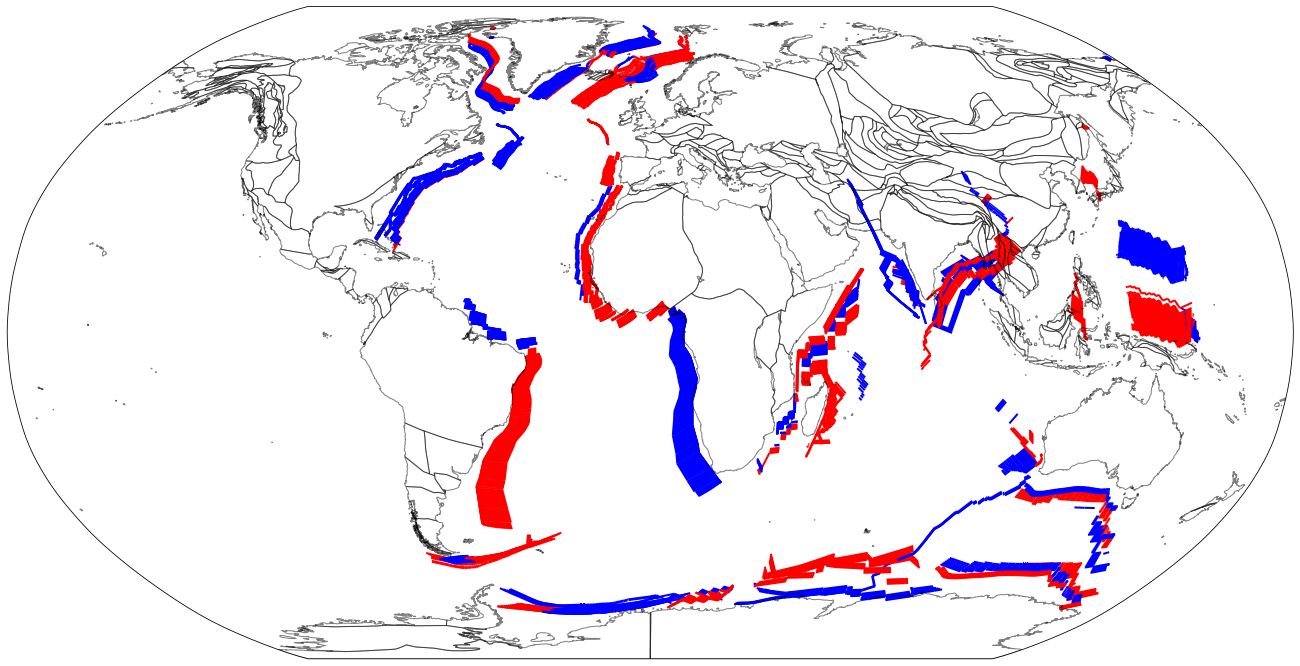

In [24]:
#plotting (but cartopy still broken?)
data_crs = ccrs.Geodetic()
poly_data_crs = ccrs.PlateCarree()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),
                       subplot_kw={'projection': ccrs.Robinson(0)})

reconstructed_coastlines = []
#pygplates.reconstruct(COBs,rotation_model,reconstructed_coastlines,0)
pygplates.reconstruct(coastlines,rotation_model,reconstructed_coastlines,0)

for ind, row in global_frame.iterrows():
3
    if ind % 600 == 0:
        print(ind)
    points = np.array([row[2], row[3], row[4], row[5]])
    point = np.array([row[1], row[0]])
    polyline = pygplates.PolylineOnSphere(zip(points[::2],points[1::2]))
    mid_point = pygplates.PointOnSphere(point)
    left_plate = row[7]
    right_plate = row[8]
    time = row[10]
    rotation_right = rotation_model.get_rotation(0, int(right_plate), int(time))
    rotation_left = rotation_model.get_rotation(0, int(left_plate), int(time))
    reconstructed_line_right = rotation_right * polyline
    reconstructed_line_left = rotation_left * polyline

    #right rotation
    lat_lon_array = reconstructed_line_right.get_points().to_lat_lon_array()
    lats = lat_lon_array[:,0]
    lons = lat_lon_array[:,1]
    
    line = LineString(zip(lons,lats))
    ax.add_geometries([line], crs=data_crs, color='red', lw=2)
    
    #left rotation
    lat_lon_array = reconstructed_line_left.get_points().to_lat_lon_array()
    lats = lat_lon_array[:,0]
    lons = lat_lon_array[:,1]
    
    line = LineString(zip(lons,lats))
    ax.add_geometries([line], crs=data_crs, color='blue', lw=2)

for n in range(len(reconstructed_coastlines)):
    #print(n)
    # pull out lat/lon vertices
    lat_lon_array = reconstructed_coastlines[n].get_reconstructed_geometry().to_lat_lon_array()
    lats = lat_lon_array[:,0]
    lons = lat_lon_array[:,1]

    # polygons need to be drawn counter clockwise to be drawn properly if they cross the dateline
    if reconstructed_coastlines[n].get_reconstructed_geometry().get_orientation() == pygplates.PolygonOnSphere.Orientation.clockwise:
        lats = np.flip(lats)
        lons = np.flip(lons)

    # create the polygon and add it to the axis note that ccrs.Geodetic() must be used to make sure that polygons that cross the dateline are drawn properly
    poly = Polygon(zip(lons,lats))

    #some polygons are very small and don't close properly, so this line just skips those area is in squared degree units (apparently)
    if poly.area < 5e-4:
        continue
        
    ax.add_geometries([poly], crs=data_crs, fc='none', alpha=0.5)
    ax.set_global()